## Expected prior knowledge
To work with this tutorial, you should be familiar with the following topics:

1. Setting up and running simulations in ESPResSo - creating particles, incorporating interactions.
2. Basic knowledge of classical electrostatics: Surface charges, dipoles ;concepts of statistical mechanics,
   Poisson-Boltzmann Equation.
3. Reduced units, as described in the ESPResSo user guide https://espressomd.github.io/doc/introduction.html#on-units


##  Introduction
#### This tutorial introduces some of the features of ESPResSo for simulating charges confined between two electrodes separated by a dielectric. In the first part we focus on a single ion pair interaction in  a narrow metallic slit-like confinement using the  ELCIC framework. Here, we test ELC against mean-field analytic solution for the electrostatic free energy of an ion-pair in a  charged slit formed by two infinitely extended, perfectly metallic walls. The pair interaction energy in this case is screened exponentially due to the presence of induced charges on the slit walls. The same induced charges at the metallic walls effectuates a net attractive force on the counterion when it approches the wall.
#### In the second part, we simulate an electrolyte solution consiting monovalent ions between dielectric walls. In this case we emulate a certain surface charge densiy on both electrodes by applying a constant potential. This results in the accumulation of electrolyte ions towards opposite electrodes.  The density profile of the ions from each electrode is compared to the exact solvable analytical Poisson-Boltzmann solution ("Gouy-Chapman  solution ") for a charged planar wall with added electrolyte solution.        

## Theoretical Background 

The normal component of electric field across a surface diving two dielectric media yields a discontinuity due to the presence of a finite surface charge density $(\epsilon_1\vec{E}_1 - \epsilon_2\vec{E}_2 ).\hat{n}=-\sigma(\vec{r})$. This equation describes the jump in the electric field across the material surface due to dielectric interface. While in the case of non-polarizable materials this jump is only due to surface charges and the potential is continuous across the interface, for polarizable materials also the polarization field P will give a contribution.  In order to solve such a system having jump dielectric constant across a surface,one must know the electric fields on both sides. Another approach is to replace this two domain problem by an equivalent one without the dielectric jump. This is achieved by introducing an additional fictitious charge i.e an induced charge density $\sigma_{ind}$ on the surface. With this method it is sufficient to know the electric field on one side of the interface and this is the well known "method of image charges". This method of an induced charge density at dielectric 2D interface is what is implemented in ELCIC to account for the dielectric contrast. 



Partially periodic ionic systems with dielectric interfaces is very often encountered in biomacromolecular and membrane studies. These system which usually consists of a confinement along one (z) direction where the confining boundary or interface imposes a dielectric discontinuity, while the other x-y directions are periodic and exhibit bulklike properties. The "electrostatic layer correction” (ELC) method proposed by Holm et. al accounts for the periodic contributions in the constrained direction by evaluating a layer correction term growing linear with N, which then can be used with any 3-D Coulomb solvers. We here use P3M (particle-particle, particle-mesh), which scales with O(N ln N). Further ELC can be extended to implement the dielectric interfaces by using the method of image charges and this is the "Electrostatic layer correction with image charges" (ELCIC) approach used in this tutorial.
  
Note: Apart from ELCIC, ESPResSo also provides ICC method where we account for a set of spatially fixed ICC particles, whose initial charges are iterated over time until they correctly represent the influence of the dielectric discontinuity.

First we import all ESPResSo features and external modules

In [1]:
import espressomd
import numpy as np
import espressomd.electrostatics
import espressomd.electrostatic_extensions
from espressomd.interactions import *
import espressomd.visualization
import espressomd.observables
import espressomd.accumulators
from scipy import integrate
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.misc import derivative
from scipy.special import *



##  System setup 
## Part A: Ion-pair in a narrow metallic slit-like confinement 
 
We define system dimensions and some physical parameters related to length , time and energy scales of our system. All physical parameters are defined in reduced units of length ($\sigma=1$; Particle size), mass ($m=1$; Particle mass), time ($t=0.005$) and elementary charge (e=1). Another important length scale is the Bjerrum Length which is the length  at which the electrostatic energy between two elementary charges is comparable to $k_BT$. Its defined as $l_B=\frac{1}{4\pi\epsilon_0\epsilon_rk_BT}$. 
In our case if we choose the ion size (sigma) in simulations equivalent to 0.3 nm in real units, then considering Bjerrum length of water at room temperature $l_B=0.71 nm$, we get $l_B\sim 2.0$ in simulations units.




In [2]:
#***************************************************
#            System Setup
#***************************************************

# Box dimensions
# To construct a narrow slit Lz << (Lx , Ly)
box_l_x = 100.
box_l_y = 100.
box_l_z = 5.

# ELC for 2D peridicity
elc_gap = 95.0

system = espressomd.System(box_l=[box_l_x, box_l_y, box_l_z+elc_gap])

# System Time
system.time_step = 0.01
system.cell_system.skin = 0.4

# Elementary charge 
q = np.array([1.0])                   

About ELCIC.....

In [3]:
# Interaction Parameters: P3M with ELCIC

Bjerrum_length = 2.0        # Electrostatic prefactor passed to P3M ; prefactor=lB KBT/e2                
accuracy = 1e-6                   
check_accuracy = 1e-6             
delta_mid_top = -1.0   #(Fully metallic case both -1)                 
delta_mid_bot = -1.0

#Lennard-Jones  Parameters

LJ_sigma=1.0
LJ_epsilon=1.0

Setting up the particles:

Our system consitutes of an ion placed between two parallel dielectric walls such that the dielectric contrasts at the interface (i.e the wall) will effectuate a force jump on the particle near the walls. So in this case to account for the 2D periodicity of the charged confined system, we use the ELC in extension wih P3M.


In [4]:
#Particle parameters

types = {"Cation": 0, "Anion": 1  ,"Electrodes": 2}
charges = {"Cation": q[0], "Anion": -q[0]  }
minimum_distance_to_wall = 0.1
distance_btw_ions = 1.0

# **********CASE 1************************
# Particle sitting at (x,y,z) and (x,y,z+1)
# Shifted between z=0 to z=box_l_z

#******************************************

P1=system.part.add(pos=[box_l_x/2.0, box_l_y/2.0, box_l_z/2.0], q=charges["Cation"])
print(f"Cation placed at position: {P1.pos}")
P2=system.part.add(pos=P1.pos + [0, 0, distance_btw_ions],q=charges["Anion"])
print(f"Anion placed at position: {P2.pos}")


Cation placed at position: [50.  50.   2.5]
Anion placed at position: [50.  50.   3.5]


In [5]:
# Instantiating  electrostatic solver P3M-ELCIC

potential_diff=0.0
p3m = espressomd.electrostatics.P3M(prefactor=Bjerrum_length, accuracy=accuracy, mesh=[58, 58, 70], cao=4)
elc = espressomd.electrostatics.ELC(actor=p3m,
                                    gap_size=elc_gap,
                                    const_pot=True,
                                    pot_diff=potential_diff,
                                    maxPWerror=check_accuracy,
                                    delta_mid_bot=delta_mid_bot,
                                    delta_mid_top=delta_mid_top)
system.actors.add(elc)


In [6]:
# instantiating particle handles p1 and p2
p1, p2 = system.part.all()

zPos = np.linspace(minimum_distance_to_wall, box_l_z - minimum_distance_to_wall-distance_btw_ions  ,50)
elc_forces = np.empty((len(zPos), 2))
elc_energy = np.empty(len(zPos))

# Shift particles from z=0 to z=box_l_z &
# call integrator each time to obtain forces
for i, z in enumerate(zPos):
    pos = np.copy(p1.pos) 
    p1.pos = [pos[0], pos[1], z ]
    pos = np.copy(p2.pos)
    p2.pos = [pos[0], pos[1], z+distance_btw_ions ]
    
    system.integrator.run(0)
    elc_forces[i, 0] = p1.f[2]
    elc_forces[i, 1] = p2.f[2]
    elc_energy[i] = system.analysis.energy()[
                    "total"]     

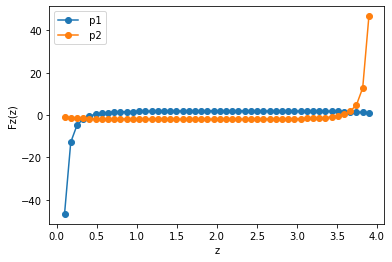

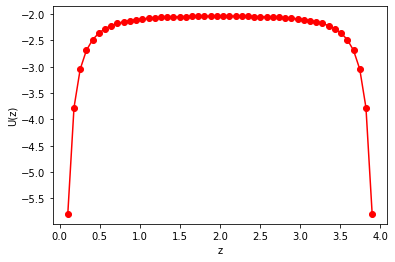

In [7]:
#******************************************************
#   Forces acting on both ions in the z-direction
#   due to induced surface charges at the dielectric 
#   interface.
#******************************************************

# Force Vs. z
plt.plot(zPos, elc_forces[:, 0], marker='o', label=" p1")
plt.plot(zPos, elc_forces[:, 1], marker='o', label=" p2")
plt.xlabel('z')
plt.ylabel('Fz(z)')
plt.legend()
plt.show()


# Energy Vs. z
plt.plot(zPos, elc_energy,  color='red' , label="sim",  marker='o')
plt.xlabel('z')
plt.ylabel('U(z)')
plt.show()

In [8]:
#******************CASE 3 *****************************************
#   Interaction energy of a dipole confined between dielectric walls 
#   as a function of separation R  
# *****************************************************************

# instantiating particle handles p1 and p2
p1, p2 = system.part.all()

xPos = np.linspace(distance_btw_ions , box_l_x / 2.0  ,50)
elc_forces_axial = np.empty((len(xPos), 2))
elc_energy_axial = np.empty(len(xPos))

for i, x in enumerate(xPos):
    p1.pos = [0, box_l_y/2.0, box_l_z/2.0]
    p2.pos = [x, box_l_y/2.0, box_l_z/2.0]
    
    system.integrator.run(0)
    elc_forces_axial[i, 0] = p1.f[0]
    elc_forces_axial[i, 1] = p2.f[0]
    elc_energy_axial[i] = system.analysis.energy()[
                    "total"]

#### Comparison with Mean field solution in an infinitely elongated narrow slit 

The electrostatic energy between two point charges in a slit-shaped charged nanopore 
formed by two infinitely extended, perfectly metallic walls is given as [Chem. Rev. 2023](https://pubs.acs.org/doi/pdf/10.1021/acs.chemrev.2c00728)  
$$ \beta\phi_{12}(z) = \frac{\beta q_1q_2}{\pi\epsilon_0\epsilon_rL}\sum_{n=1}^{\infty}K_0(\pi nr/L)$$
$$ = \frac{4l_BZ_1Z_2}{L}\sum_{n=1}^{\infty}K_0(\pi nr/L) $$

Here, $\beta = 1/k_BT$, $q_1$, $q_2$ are the ion charges with valencies $Z_1$, $Z_2$, respectively. $K_0(x)$
is the zero-order modified Bessel function of the second kind, $L$ is the slit width and $\epsilon_0$ is the 
vaccum permittivity.



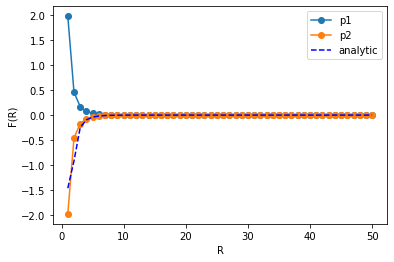

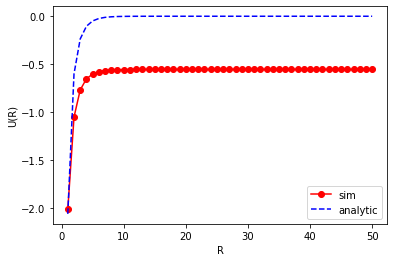

In [9]:
# ******************************************************
#                Analytical mean  PB Solution to CASE 3
#              (  Force on a dipole at separation R  )
#*******************************************************

analytic_forces=[]
analytic_energy=[]
analytic_forces_axial = []
analytic_energy_axial = []

epsilon=1.0 
prefactor_energy = 4.0*Bjerrum_length*q[0]*-q[0]/(box_l_z)#.reshape(-1, 1))

for i in xPos:
    force_anl=0
    energy_anl=0
    for j in range(1, 100):
        K_0=kn(0,(np.pi *j*i/box_l_z))
        energy_anl  +=  K_0 
    #   force_anl +=  j * np.pi / box_l_z * kn(1, (np.pi * j * i / box_l_z))
     
    analytic_energy.append(prefactor_energy*energy_anl )
    #analytic_forces.append(-prefactor_force*force_anl )
analytic_forces = -np.gradient(analytic_energy, xPos)

plt.plot(xPos, elc_forces_axial[:, 0], marker='o', label="p1")
plt.plot(xPos, elc_forces_axial[:, 1], marker='o', label="p2")
plt.plot(xPos, analytic_forces, label="analytic", linestyle="dashed", color="blue")
plt.legend()
plt.xlabel('R')
plt.ylabel('F(R)')
plt.show()

plt.xlabel('R')
plt.ylabel('U(R)')
plt.plot(xPos, elc_energy_axial,  color='red' , label="sim",  marker='o')
plt.plot(xPos, analytic_energy, label="analytic", linestyle="dashed", color="blue")
plt.legend()
plt.show()

<font color='red'> Explain discrepancy in the potential energy term in terms of self energy ...???


## Part B: Ionic solution between dielectric walls with applied potential difference

Understanding the electric double layer (EDL) is crucial for the study
of a variety of systems, including colloidal suspensions, charged biological
macromolecules and membranes. Poisson-Boltzmann (PB) theory based on a mean-field formalism properly describes the behavior of Coulomb fluids composed of monovalent ions at low concentrations in the
vicinity of weakly charged interfaces. However, for strongly charged systems, where correlation and finite size effects begin to dominate the system dynamics, the PB theory falls inadequate. Our goal in this module is to demonstrate how coarse grained implicit solvent simualtions can corroborate some of these approximate theories.

Here, we look at the ion density profile between two dielectric walls with constant potential applied to them. 
In this case the inclusion of dielectric inhomogeneities demands a detailed calculation of the image
effects that involve the full solution of the Poisson equation on the fly. This is dealt in a computational cost effective way using ELCIC method, to treat the image charge effect in the presence of 2D dielectric bounding
interfaces.  


Next, we define the simulation units and set the parameters which define our system and the interactions:

In [10]:
#*****************************************************************************
#    .System setup 
#*****************************************************************************

# Remove previously added actors (p3m, elc)
system.actors.clear()
system.constraints.clear()

# Remove the existing Cation and Anion Ionpair. 
system.part.all().remove()

# System Resize
# Keep the density fixed to rescale the system for changing N values if needed 

n_ionpairs=200
sigma_in_SI_units = 3.55e-10 # sigma in SI units
avo = 6.022e+23 # Avogadro's number in SI units
PREF = 1 / (10**3 * avo *sigma_in_SI_units**3) # prefactor to convert from 1/sigma^3 to  mol/L
rho_pb_in_SI_units=0.001# Density (N+ + N-)/V  mol/L
rho_pb=rho_pb_in_SI_units/PREF#0.00003#0.8/(30**3.0)
p_factor=4.0*np.pi*Bjerrum_length
kappa = np.sqrt( p_factor* rho_pb) 
debye_length = 1/kappa
print(f"A Debye length of {debye_length} (in simulation units)", \
       "demands the channel width to be atleast 10 times db in order to obtain a decoupled", \
       "ion density profile from each electrodes by retrieving a proper bulk regime towards the channel centre.")
       
Lz_box=600
boxL_3 = int(((2.0*n_ionpairs) /rho_pb ))
Lx_box = int((boxL_3/Lz_box)**(1.0/2.0))

box_l_x = Lx_box
box_l_y = Lx_box
box_l_z = Lz_box
elc_gap = int(0.3 * box_l_z)
system.box_l = [box_l_x, box_l_y, box_l_z+elc_gap]
system.time_step = 0.005
print(f"For {n_ionpairs} ionpairs a density of {(n_ionpairs*2.0*PREF)/(box_l_x*box_l_y*box_l_z)}", \
      f"mMol corresponds to a box of dimension {box_l_x},{box_l_y},{box_l_z}") 




A Debye length of 38.42971511474027 (in simulation units) demands the channel width to be atleast 10 times db in order to obtain a decoupled ion density profile from each electrodes by retrieving a proper bulk regime towards the channel centre.
For 200 ionpairs a density of 0.001003884215720744 mMol corresponds to a box of dimension 157,157,600


After defining the simulation parameters, we set up the system that we want to simulate. We setup an electrolyte solution made of monovalent cations (Np) and anions (Np) between two metallic electrodes at constant potential. Firstly we add two wall constraints at the 0 and Lz to stop particles from crossing the boundaries. Refer [espressomd.constraints.ShapeBasedConstraint](https://espressomd.github.io/doc/espressomd.html#espressomd.constraints.ShapeBasedConstraint)
in the documentation to set up constraints. Then we place all the ion pairs at random positions between the electrodes.  

In [11]:
# ADDING ELECTRODES
wall_offset=0

# (BOTTOM WALL) normal pointing in the +z direction, at z=wall_offset 
floor = espressomd.shapes.Wall(normal=[0, 0, 1], dist=wall_offset)
c1 = system.constraints.add(
    particle_type=types["Electrodes"], penetrable=True, only_positive=False, shape=floor)

# (TOP WALL) normal pointing in the -z direction, at z=box_l_z-wall_offset
ceil = espressomd.shapes.Wall(normal=[0, 0, -1], dist=-(box_l_z - wall_offset))   
c2 = system.constraints.add(
    particle_type=types["Electrodes"], penetrable=True, only_positive=False, shape=ceil)


# ADDING IONPAIRS 
offset=10 # To stop the particle to cross the wall at integration 
Init_part_btw_z1=0+offset 
Init_part_btw_z2=box_l_z-offset
ion_pos=np.empty((3),dtype=float)

for i in range (n_ionpairs):
    ion_pos[0] = np.random.random(1) * system.box_l[0]
    ion_pos[1] = np.random.random(1) * system.box_l[1]
    ion_pos[2] = np.random.random(1) * (Init_part_btw_z2-Init_part_btw_z1) + Init_part_btw_z1
    system.part.add(pos=ion_pos, type=types["Cation"]  , q=charges["Cation"])
    
for i in range (n_ionpairs):
    ion_pos[0] = np.random.random(1) * system.box_l[0]
    ion_pos[1] = np.random.random(1) * system.box_l[1]
    ion_pos[2] = np.random.random(1) * (Init_part_btw_z2-Init_part_btw_z1) + Init_part_btw_z1
    system.part.add(pos=ion_pos, type=types["Anion"]  , q=charges["Anion"])
    
    


    

Now, we add interactions:
For excluded volume interactions, we add WCA kind of potential. For the (2D+h) electrostatic with dielectrics 
we choose the ELCIC  with P3M.

Refer to the documentation to set up the [WCA interaction](https://espressomd.github.io/doc/espressomd.html#espressomd.interactions.WCAInteraction) under [Non-bonded](https://espressomd.github.io/doc/inter_non-bonded.html) section.

Refer the documentation to set up [ELCIC with P3M](https://espressomd.github.io/doc/electrostatics.html#electrostatic-layer-correction-elc) under the [electrostatics](https://espressomd.github.io/doc/electrostatics.html) section. 

In [12]:
#***************************************************************
#                   Adding WCA interactions 
#***************************************************************

for  key, val in types.items():
    for key1, val1 in types.items():
        system.non_bonded_inter[val, val1].wca.set_params(epsilon=LJ_epsilon, sigma=LJ_sigma)

#***************************************************************
#                 Adding ELC-P3M electrostatic solver   
#***************************************************************

potential_diff=4.0
accuracy = 1e-3
p3m = espressomd.electrostatics.P3MGPU(prefactor=Bjerrum_length, accuracy=accuracy, mesh=[58, 58, 70], cao=4)
elc = espressomd.electrostatics.ELC(actor=p3m,
                                    gap_size=elc_gap,
                                    const_pot=True,
                                    pot_diff=potential_diff,
                                    maxPWerror=check_accuracy,
                                    delta_mid_bot=delta_mid_bot,
                                    delta_mid_top=delta_mid_top)
system.actors.add(elc)

Before we can start the simulation, we need to remove the overlap between particles to avoid large forces which would crash the simulation. For this, we use the steepest descent integrator with a relative convergence criterion for forces and energies.



In [13]:
#  Relax the overlaps with steepest descent

system.integrator.set_steepest_descent(f_max=10, gamma=50.0,
                                       max_displacement=0.02)
system.integrator.run(1000)
system.integrator.set_vv() # Switch bach to velocity Verlet 


# Add thermostat 
thermostat_seed = np.random.randint(np.random.randint(1000000))
system.thermostat.set_langevin(kT=1.0, gamma=0.1, seed=thermostat_seed)

After removing the overlaps, the next step is to equiliberate the system via integrator calls [system.integrator.run()](https://espressomd.github.io/doc/integration.html?highlight=integrator%20run) sufficiently longly to relax the system to its equilibrium state before production runs. However, looking at the elongated time for our system of N=200 ions to reach their stable configurations, we have provided a file of equiliberated data. The evolution of the ion density profile is plotted below to give an idea of the equiliberation timescales here.

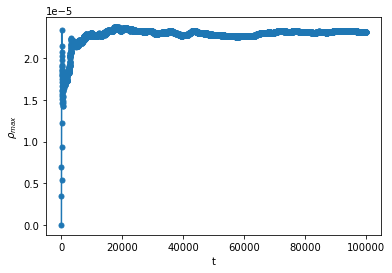

In [14]:
read_density = np.loadtxt('chh_V2_density_max_N50.dat')
plt.plot(read_density[:,0], read_density[:,1], marker='o', markersize=5)
#plt.xlim((-1000, 20000))
plt.xlabel("t")
plt.ylabel(r"$\rho_{max}$")

plt.show()

In [15]:
equib_samples=2000
for tm in tqdm(range(equib_samples)):
        system.integrator.run(50)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [08:58<00:00,  9.28it/s]


In [16]:

    #*************************************************************
#  PART 2:       SETTING ACCUMULATORS FOR DENSITY PROFILE AT GIVEN E for equiliberation with desired potential
#**************************************************************
# PRODUCTION RUNS
Ion_id=[]
Cations = system.part.select(type=types["Cation"])
Cations_id=[]
for i in Cations:
    Cations_id.append(i.id)
    Ion_id.append(i.id)
    
Anions = system.part.select(type=types["Anion"])
Anions_id=[]
for i in Anions:
    Anions_id.append(i.id)
    Ion_id.append(i.id)
    

  
# Accumulator 1 : observable::Density_Profile
density_profile = espressomd.observables.DensityProfile(ids=Cations_id,
                                                       n_x_bins=1,
                                                       n_y_bins=1,
                                                       n_z_bins=2*int(system.box_l[2] - elc_gap),
                                                       min_x=0,
                                                       min_y=0,
                                                       min_z=0,
                                                       max_x=system.box_l[0],
                                                       max_y=system.box_l[1],
                                                       max_z=system.box_l[2] - elc_gap)

density_accumulator = espressomd.accumulators.MeanVarianceCalculator(obs=density_profile, delta_N=20)


density_profile_1 = espressomd.observables.DensityProfile(ids=Anions_id,
                                                       n_x_bins=1,
                                                       n_y_bins=1,
                                                       n_z_bins=2*int(system.box_l[2] - elc_gap),
                                                       min_x=0,
                                                       min_y=0,
                                                       min_z=0,
                                                       max_x=system.box_l[0],
                                                       max_y=system.box_l[1],
                                                       max_z=system.box_l[2] - elc_gap)

density_accumulator_1 = espressomd.accumulators.MeanVarianceCalculator(obs=density_profile_1, delta_N=20)


#icc_plate_1 = system.part.select(lambda p: p.id >= icc.first_id and p.id<(nicc_per_electrode+icc.first_id))
#icc_plate_2 = system.part.select(lambda p: p.id >= (nicc_per_electrode+icc.first_id) and p.id<(2*nicc_per_electrode+icc.first_id))
num_of_samples=9000#400000
Pot_applied=np.linspace(0, 10.0, 10 )

sigma_U=[]
U=[]
for i in range(1):
    #electric_field.E=[0, 0, i]
    system.actors.remove(elc)
    potential_diff=2.0
    p3m = espressomd.electrostatics.P3MGPU(prefactor=Bjerrum_length, accuracy=accuracy, mesh=[58, 58, 70], cao=4)
    elc = espressomd.electrostatics.ELC(actor=p3m,
                                    gap_size=elc_gap,
                                    const_pot=True,
                                    pot_diff=potential_diff,
                                    maxPWerror=check_accuracy,
                                    delta_mid_bot=delta_mid_bot,
                                    delta_mid_top=delta_mid_top)
    system.actors.add(elc)
    #system.constraints.remove(electric_field)
    #electric_field = espressomd.constraints.LinearElectricPotential(E=[0.,0.,i], phi0=0.)
      

    #system.constraints.add(electric_field)
    acc_sigma = 0# accumulator
    counter_sigma = 0# Counter
    #system.integrator.run(25000)##tau  = 25000 steps, 125 time units

    print("No Equiliberation !!")
    
    #**************************
    #Accumulators Instantiated 
    #**************************
    
    system.auto_update_accumulators.clear()
    system.auto_update_accumulators.add(density_accumulator)
    system.auto_update_accumulators.add(density_accumulator_1)
    
    #******************************
    #Accumulators Intantiation Done
    #******************************
    times=[]
    e_total=[]
    times_rho_max=[]
    rho_max=[]
    for tm in tqdm(range(num_of_samples)):
        system.integrator.run(50)
        #acc_sigma = acc_sigma +  sum(icc_plate_1.q)/(box_l**2)
        #counter_sigma +=1
        if(tm%10==0):
            times.append( system.time)
            energy = system.analysis.energy()
            e_total.append( energy['total'])
            
        
            
        if(tm%50==0):
            cation_profile_mean = density_accumulator.mean()[0, 0, :]
            zs = density_profile.bin_centers()[0, 0, :, 2]
            anion_profile_mean = density_accumulator_1.mean()[0, 0, :]
            zs_1 = density_profile_1.bin_centers()[0, 0, :, 2]
            rho_max.append(anion_profile_mean[5])
            times_rho_max.append( system.time)
            np.savetxt('chh_trial_cation_profile_N50.dat', np.column_stack((zs,cation_profile_mean)),fmt='%.7f\t%.7f\t', delimiter='\t')
            np.savetxt('chh_trial_anion_profile_N50.dat', np.column_stack((zs_1,anion_profile_mean)),fmt='%.7f\t%.7f\t', delimiter='\t')
    
            np.savetxt('chh_trial_charge_density_profile_N50.dat', np.column_stack((zs, (q[0]*cation_profile_mean)+(-q[0]*anion_profile_mean))),fmt='%.7f\t%.7f\t', delimiter='\t')
            np.savetxt('chh_trial_energy_equib_N50.dat', np.column_stack((times,e_total )),fmt='%.7f\t%.7f\t', delimiter='\t')

            np.savetxt('chh_trial_density_max_N50.dat', np.column_stack((times_rho_max,rho_max )),fmt='%.7f\t%.7f\t', delimiter='\t')

   
    print ( " \n - - - > Analysis Density Profile " )

    
    #print(f"Sigma for potential  {i} : ", (acc_sigma/counter_sigma))
    
    
    
    

    #sigma_U.append(acc_sigma/counter_sigma)
    #U.append(i)
    

    

  0%|                                                                                                              | 0/9000 [00:00<?, ?it/s]

No Equiliberation !!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 9000/9000 [17:14<00:00,  8.70it/s]

 
 - - - > Analysis Density Profile 


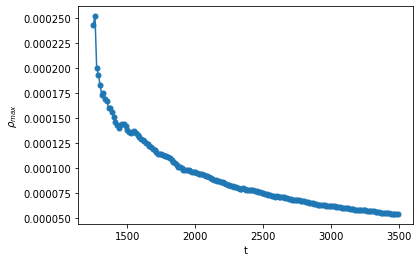

In [19]:
read_density_1 = np.loadtxt('chh_trial_density_max_N50.dat')
#plt.plot(read_density[:,0], read_density[:,1], marker='o', markersize=5)
plt.plot(read_density_1[:,0], read_density_1[:,1], marker='o', markersize=5)

#plt.xlim((-1000, 20000))
plt.xlabel("t")
plt.ylabel(r"$\rho_{max}$")

plt.show()

In [22]:
for tm in tqdm(range(9000)):
    system.integrator.run(50)
        #acc_sigma = acc_sigma +  sum(icc_plate_1.q)/(box_l**2)
        #counter_sigma +=1
    if(tm%10==0):
        times.append( system.time)
        energy = system.analysis.energy()
        e_total.append( energy['total'])
            
        
            
    if(tm%50==0):
        cation_profile_mean = density_accumulator.mean()[0, 0, :]
        zs = density_profile.bin_centers()[0, 0, :, 2]
        anion_profile_mean = density_accumulator_1.mean()[0, 0, :]
        zs_1 = density_profile_1.bin_centers()[0, 0, :, 2]
        rho_max.append(anion_profile_mean[5])
        times_rho_max.append( system.time)
        np.savetxt('chh_trial_cation_profile_N50.dat', np.column_stack((zs,cation_profile_mean)),fmt='%.7f\t%.7f\t', delimiter='\t')
        np.savetxt('chh_trial_anion_profile_N50.dat', np.column_stack((zs_1,anion_profile_mean)),fmt='%.7f\t%.7f\t', delimiter='\t')
    
        np.savetxt('chh_trial_charge_density_profile_N50.dat', np.column_stack((zs, (q[0]*cation_profile_mean)+(-q[0]*anion_profile_mean))),fmt='%.7f\t%.7f\t', delimiter='\t')
        np.savetxt('chh_trial_energy_equib_N50.dat', np.column_stack((times,e_total )),fmt='%.7f\t%.7f\t', delimiter='\t')

        np.savetxt('chh_trial_density_max_N50.dat', np.column_stack((times_rho_max,rho_max )),fmt='%.7f\t%.7f\t', delimiter='\t')

   
print ( " \n - - - > Analysis Density Profile " )

    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 9000/9000 [17:49<00:00,  8.41it/s]

 
 - - - > Analysis Density Profile 


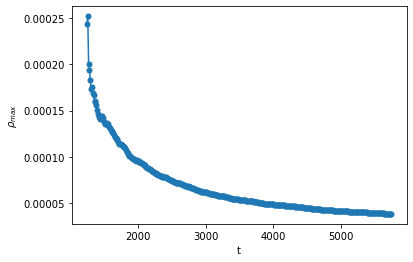

In [23]:
read_density = np.loadtxt('chh_V2_density_max_N50.dat')
read_density_1 = np.loadtxt('chh_trial_density_max_N50.dat')
#plt.plot(read_density[:,0], read_density[:,1], marker='o', markersize=5)
plt.plot(read_density_1[:,0], read_density_1[:,1], marker='o', markersize=5)

#plt.xlim((-1000, 20000))
plt.xlabel("t")
plt.ylabel(r"$\rho_{max}$")

plt.show()

# 